In [2]:
import symmetrize
symmetrize.__version__

'0.5.5'

In [3]:
import numpy as np
from symmetrize import pointops as po, tps, sym
import scipy.ndimage as ndi
import scipy.io as sio
import matplotlib.pyplot as plt

### 1. Load data

In [4]:
fpath = r'..\resources\data\WSe2_data.mat'

In [5]:
data = sio.loadmat(fpath)['data']
data.shape

(4, 100, 100)

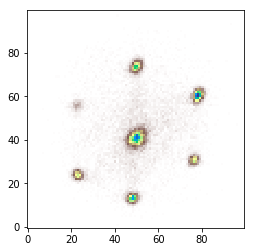

In [6]:
# Select an energy slice with sharp features as the image for transform estimation
Eslice = data[0,...]
plt.imshow(data[0,...], origin='lower', cmap='terrain_r')

### 2. Determine landmarks

In [7]:
# Detect peaks as landmarks
pks = po.peakdetect2d(Eslice, method='daofind', fwhm=8)

# Select the center from the set of landmarks and separate from the vertices
pcent, psur = po.pointset_center(pks, method='centroidnn')

# Order the point set in counterclockwise fashion
psur_ord = po.pointset_order(psur, direction='ccw')

In [8]:
# Alternatively, use pointset_locate() to combine the three operations.
# pcent, psur_ord = po.pointset_locate(Eslice, method='daofind', centermethod='centroidnn', direction='ccw', fwhm=8)

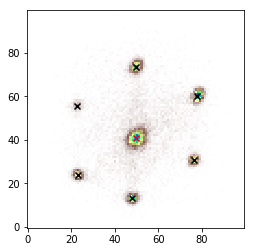

In [9]:
# View the points labelled on top of the image
plt.imshow(Eslice, origin='lower', cmap='terrain_r')
plt.scatter(psur_ord[:,1], psur_ord[:,0], c='k', marker='x')
plt.scatter(pcent[1], pcent[0], c='r', marker='x')

### 3. Calculate the symmetrized landmarks

In [10]:
arot = np.ones(5,)*60
# ascale = np.ones([1, 6])[0, :]
mcvd = po.cvdist(psur_ord, pcent).mean()
ptargs = sym.rotVertexGenerator(pcent, fixedvertex=psur_ord[0, :], cvd=mcvd, arot=arot,
                                direction=-1, scale=1, ret='all')

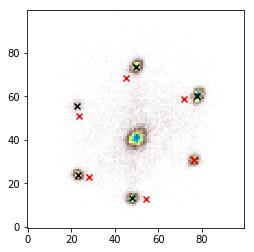

In [11]:
plt.imshow(Eslice, origin='lower', cmap='terrain_r')
plt.scatter(psur_ord[:, 1], psur_ord[:, 0], c='k', marker='x')
plt.scatter(ptargs[:, 1], ptargs[:, 0], c='r', marker='x')

### 4. Calculate the deformation field and apply to the image

In [12]:
interp_order = 3 # interpolation order
Eslice_warped, spline_warp = tps.tpsWarping(psur_ord, ptargs, Eslice, None, interp_order, ret='all')

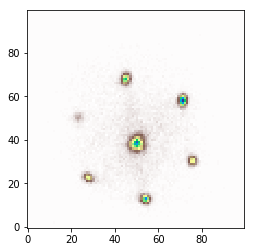

In [13]:
plt.imshow(Eslice_warped, origin='lower', cmap='terrain_r')

### 5. Composing deformation field with matrix transforms

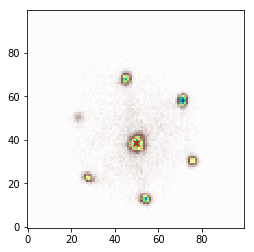

In [14]:
# Adjust the image rotation
pcent2, _ = po.pointset_locate(Eslice_warped, method='daofind', centermethod='centroidnn', direction='ccw', fwhm=8)

plt.imshow(Eslice_warped, origin='lower', cmap='terrain_r')
plt.scatter(pcent2[1], pcent2[0], c='r', marker='x')

#### Compose a spline deformation with a rotation

In [15]:
coordmat = sym.coordinate_matrix_2D(Eslice_warped, coordtype='homogeneous', stackaxis=0).astype('float64')
rdisp, cdisp = sym.rotationDF(coordmat, stackaxis=0, angle=-9, ret='displacement', center=pcent2)

In [16]:
# Compose deformation fields by summing pixelwise displacements
rdeform = spline_warp[0] + rdisp
cdeform = spline_warp[1] + cdisp

In [17]:
# Interpolate the image after nonlinear transformation
Eslice_transformed = ndi.map_coordinates(Eslice, [rdeform, cdeform], order=interp_order)

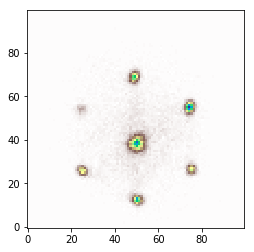

In [18]:
plt.imshow(Eslice_transformed, origin='lower', cmap='terrain_r')

### 5. Using deformation/displacement field to transform image stack

In [19]:
data_warped = sym.applyWarping(data, axis=0, warptype='deform_field', dfield=[rdeform, cdeform])

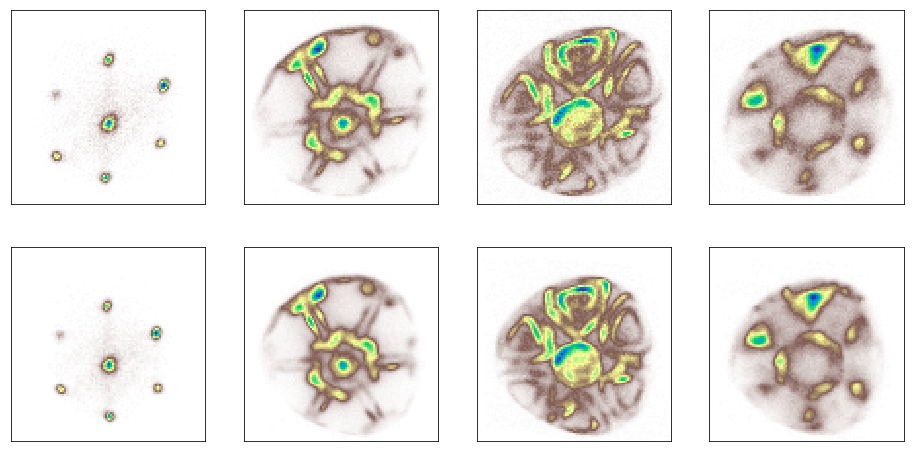

In [20]:
# Visualize the images before and after applying the transform
f, ax = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    ax[0,i].imshow(data[i,...], origin='lower', cmap='terrain_r')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    ax[1,i].imshow(data_warped[i,...], origin='lower', cmap='terrain_r')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])